In [2]:
import pandas as pd
from glob import glob
#from bs4 import BeautifulSoup as soup
import plotly.express as px
#from pymarc import parse_xml_to_array
#import re
import geopy.geocoders as geo

from geopy.extra.rate_limiter import RateLimiter
#from tqdm import tqdm

In [2]:
path = './data/*.xml'
files = glob(path)
collection = pd.DataFrame()

In [3]:
def make_collection(records):
    for record in records:
        global collection
        #idn
        if record['016']:
            idn = record['016']['a']
        
        #author
        if record['100']:
            if record['100']['4'] == 'aut':
                author = record['100']['a']
            else:
                author = None
        
        #recipient
        if record['700']:
            if record['700']['4'] == 'rcp':
                recipient = record['700']['a']
            else:
                recipient = None
                
        #year    
        if record['264']:
            if record['264']['c']:
                year = record['264']['c'].strip()
            else:
                year = None
        else:
            year = None

        #place
        if record['264']:
            if record['264']['a']:
                place = record['264']['a'].strip()
            elif record['264']['b']:
                place = record['264']['b'].strip()
            else:
                place = None
        else:
            place = None
        #title
        title = record.title().strip()

        entry = {'idn': idn, 'author': author, 'recipient': recipient, 'year': year, 'title': title, 'place': place}
        collection = collection.append(entry, ignore_index=True)

In [4]:
for file in tqdm(files):
    records = parse_xml_to_array(file)
    make_collection(records)
collection

100%|██████████| 15/15 [00:04<00:00,  3.22it/s]


,author,idn,place,recipient,title,year
0,"Lewisohn, Ludwig",99681471X,"Tucson, Ariz.","Heilbut, Iwan",Korrespondenz,1943-1943
1,"Liedke, Herbert R.",996815287,"West Englewood, NJ u.a.","Heilbut, Iwan",Korrespondenz,1948-1950
2,"Lienek, Heinz",996816038,Berlin-Neukölln,"Heilbut, Iwan",Korrespondenz,1948-1969
3,"Rosin, Katherine",996816887,"New York, NY","Heilbut, Iwan",Korrespondenz,1944-1944
4,"Schlüter, Marguerite Valerie",996817344,Wiesbaden,"Heilbut, Iwan",Korrespondenz,1970-1970
...,...,...,...,...,...,...
1396,"Hester, Lilian",996253602,"Glen Cove, NY","Heilbut, Iwan",Korrespondenz,1942-1942
1397,"Heynicke, Kurt",99625806X,Merzhausen über Freiburg im Breisgau,"Heilbut, Iwan",Korrespondenz,1948-1953
1398,"Hiltbrunner, Hermann",996261338,Uerikon am Zürichsee,"Heilbut, Iwan",Korrespondenz,1948-1948
1399,"Hinzelmann, Elsa Margot",99626244X,Zürich,"Heilbut, Iwan",Korrespondenz,1941-1941


In [7]:
geolocator = geo.Nominatim(user_agent='dea-places')
geo.options.default_timeout = 10
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [8]:
tqdm.pandas()
unique_places = pd.DataFrame(collection.place.value_counts().index.tolist(), columns=['place'])
unique_places['location'] = unique_places['place'].progress_apply(geocode)
unique_places['point'] = unique_places['location'].apply(lambda loc: tuple(loc.point) if loc else None)
unique_places


100%|██████████| 294/294 [05:43<00:00,  1.17s/it]


,place,location,point
0,"New York, NY","(New York, United States of America, (40.71272...","(40.7127281, -74.0060152, 0.0)"
1,München,"(München, Oberbayern, Bayern, Deutschland, (48...","(48.1371079, 11.5753822, 0.0)"
2,Berlin,"(Berlin, 10117, Deutschland, (52.5170365, 13.3...","(52.5170365, 13.3888599, 0.0)"
3,München u.a.,"(A, Olympisches Dorf, Bezirksteil Am Riesenfel...","(48.1791699, 11.5541431, 0.0)"
4,Hamburg,"(Hamburg, 20095, Deutschland, (53.550341, 10.0...","(53.550341, 10.000654, 0.0)"
...,...,...,...
289,München-Geiselgasteig,"(Geiselgasteig, Grünwald, Landkreis München, O...","(48.0626315, 11.5479446, 0.0)"
290,Gaeta,"(Gaeta, Latina, Lazio, 04024, Italia, (41.2183...","(41.218312, 13.56281, 0.0)"
291,Stockdorf bei München,"(Tannroda, Landkreis Weimarer Land, Thüringen,...","(50.8596222, 11.2460637, 0.0)"
292,Stuttgart-Vaihingen u.a.,None,None


In [9]:
collection = collection.merge(unique_places, on='place')

In [10]:
collection

,author,idn,place,recipient,title,year,location,point
0,"Lewisohn, Ludwig",99681471X,"Tucson, Ariz.","Heilbut, Iwan",Korrespondenz,1943-1943,"(Tucson, Pima County, Arizona, United States, ...","(32.2218917, -110.9262353, 0.0)"
1,"Liedke, Herbert R.",996815287,"West Englewood, NJ u.a.","Heilbut, Iwan",Korrespondenz,1948-1950,"(West Englewood, Teaneck Township, Bergen Coun...","(40.9020512, -74.0046211, 0.0)"
2,"Lienek, Heinz",996816038,Berlin-Neukölln,"Heilbut, Iwan",Korrespondenz,1948-1969,"(Berlin-Neukölln, Sterndamm, Johannisthal, Tre...","(52.4454318, 13.443459827373, 0.0)"
3,"Rosin, Katherine",996816887,"New York, NY","Heilbut, Iwan",Korrespondenz,1944-1944,"(New York, United States of America, (40.71272...","(40.7127281, -74.0060152, 0.0)"
4,"Lindt, Peter M.",996925112,"New York, NY","Heilbut, Iwan",Korrespondenz,1943-1943,"(New York, United States of America, (40.71272...","(40.7127281, -74.0060152, 0.0)"
...,...,...,...,...,...,...,...,...
1375,"Hesse, Ninon",996231145,Montagnola,"Heilbut, Iwan",Korrespondenz,1947-1947,"(La Montagnola, Cascia, Perugia, Umbria, 06043...","(42.6458314, 13.0313757, 0.0)"
1376,"Hester, Lilian",996253602,"Glen Cove, NY","Heilbut, Iwan",Korrespondenz,1942-1942,"(Glen Cove, Nassau County, New York, United St...","(40.862755, -73.6336094, 0.0)"
1377,"Heynicke, Kurt",99625806X,Merzhausen über Freiburg im Breisgau,"Heilbut, Iwan",Korrespondenz,1948-1953,None,None
1378,"Hiltbrunner, Hermann",996261338,Uerikon am Zürichsee,"Heilbut, Iwan",Korrespondenz,1948-1948,None,None


In [34]:
collection['lat'] = collection['point'].str.get(0)
collection['lon'] = collection['point'].str.get(1)

In [37]:
collection.to_csv('collection.csv', index=None)

In [3]:
collection = pd.read_csv('collection.csv')

In [9]:
fig = px.scatter_geo(collection[collection.recipient == 'Heilbut, Iwan'], lat='lat', lon='lon', scope='world',
                        hover_data=['place', 'recipient'], color='author')

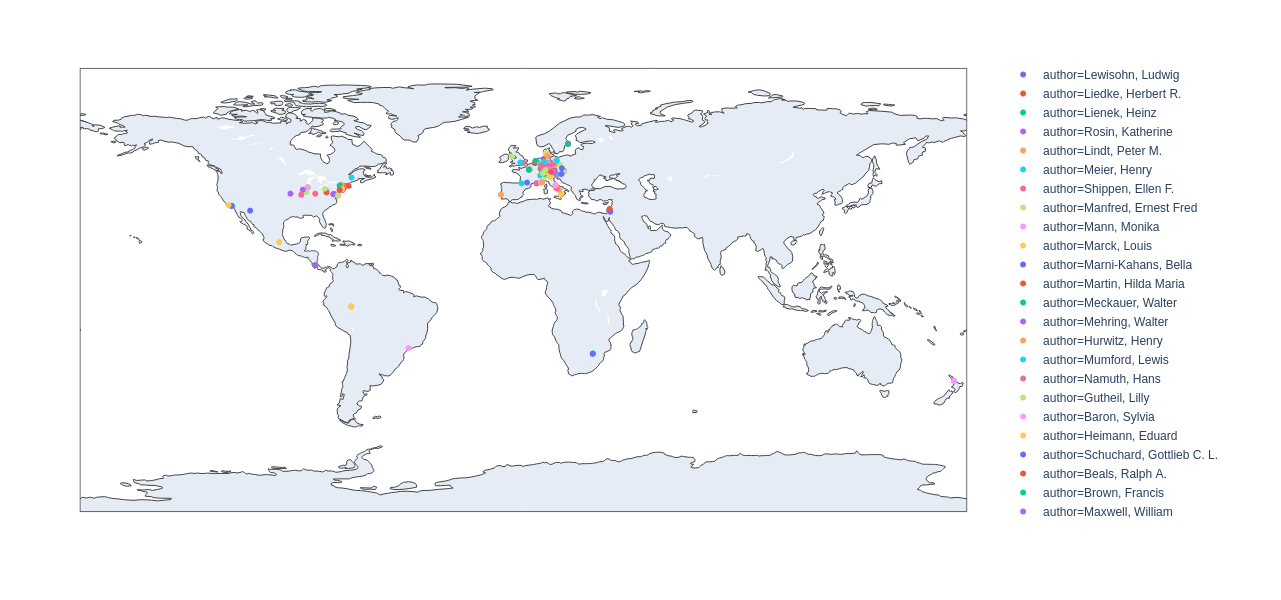

In [10]:
fig.show()